In [ ]:
# Install dependencies
!pip install "langgraph>=0.6.4" "langchain-tavily>=0.2.11" "langgraph-checkpoint-sqlite>=2.0.11" "python-dotenv>=0.9.9" "langchain-openai>=0.3.29" "langchain-anthropic>=0.3.18"

In [11]:
import os
from typing import Literal
from typing_extensions import TypedDict

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field

# Initialize core components
load_dotenv()  # Load API keys from .env file
model = init_chat_model("anthropic:claude-sonnet-4-20250514")  # Claude for classification and responses
search = TavilySearch(max_results=2)  # Web search tool

class SearchClassification(BaseModel):
    """Pydantic model for structured AI decision-making."""
    needs_search: bool = Field(..., description="Whether web search is required")
    search_query: str = Field(default="", description="Optimized search query if needed")

class State(TypedDict):
    """LangGraph state - shared data between nodes."""
    messages: list          # Conversation history
    search_results: str     # Web search results (if any)
    needs_search: bool      # Classification decision
    search_query: str       # Optimized query for search

def classify_search_need(state: State) -> State:
    """Use AI to determine if web search is needed."""
    user_query = state["messages"][-1].content
    classifier = model.with_structured_output(SearchClassification)
    
    classification_prompt = SystemMessage(content="""
        Determine if this query needs web search for current/real-time information.
        
        Search needed for: current events, real-time data, recent updates, "latest" queries
        No search for: general knowledge, historical facts, explanations, how-to questions
    """)
    
    classification = classifier.invoke([classification_prompt, HumanMessage(content=user_query)])
    
    return {
        "needs_search": classification.needs_search,
        "search_query": classification.search_query or user_query
    }

def route_decision(state: State) -> Literal["search", "respond"]:
    """Step 2: Route to either search or direct response based on classification."""
    return "search" if state["needs_search"] else "respond"

def search_web(state: State) -> State:
    """Step 3a: Perform web search using Tavily (if classification said search needed)."""
    try:
        # Use the optimized search query from classification
        results = search.invoke(state["search_query"])
        state["search_results"] = str(results)
    except Exception as e:
        # Handle search failures gracefully
        state["search_results"] = f"Search error: {e}"
    return state

def respond(state: State) -> State:
    """Step 3b: Generate final response using Claude (with search context if available)."""
    messages = state["messages"].copy()
    
    # Add search results as context if we have them
    if state.get("search_results"):
        context = SystemMessage(content=f"SEARCH RESULTS:\n{state['search_results']}\n\nUse these facts to answer the user's question.")
        messages.insert(0, context)
    
    # Generate response with or without search context
    response = model.invoke(messages)
    return {"messages": [response]}

def create_app():
    """Build the LangGraph workflow with nodes and conditional routing."""
    graph = StateGraph(State)
    
    # Add processing nodes
    graph.add_node("classify", classify_search_need)    # Step 1: Classify search need
    graph.add_node("search", search_web)                # Step 3a: Web search
    graph.add_node("respond", respond)                  # Step 3b: Generate response
    
    # Define the flow
    graph.add_edge(START, "classify")                   # Always start with classification
    graph.add_conditional_edges("classify", route_decision, {
        "search": "search",                             # If search needed -> search first
        "respond": "respond"                            # If no search needed -> respond directly
    })
    graph.add_edge("search", "respond")                 # After search -> always respond
    graph.add_edge("respond", END)                      # Response is always the end
    
    return graph.compile()  # Compile into executable workflow


if __name__ == "__main__":
    graph = create_app()

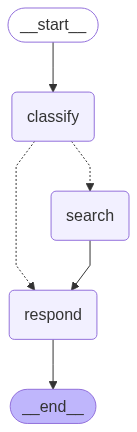

In [12]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not generate graph image: {e}")